In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from collections import Counter

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    # TODO add data agumentation here
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

data_path = 'realwaste-main/RealWaste'
model_path = 'models/model.pth'
dataset = datasets.ImageFolder(root=data_path, transform=transform)


dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

n_classes = len(dataset.classes)
images, labels = next(iter(dataloader))

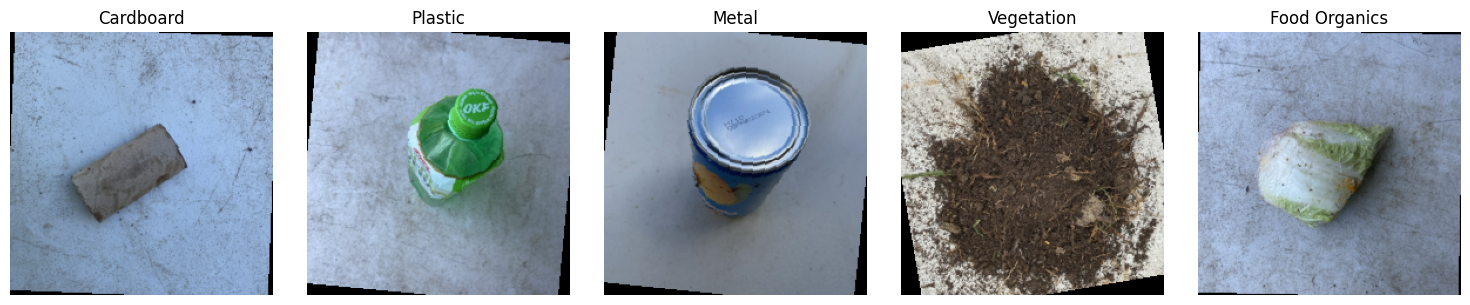

In [2]:
import matplotlib.pyplot as plt


# Let's show the first 5 images
num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(15, 3))  # 1 row, N columns
class_names = dataset.classes 
for i in range(num_images):
    img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    img = img * 0.5 + 0.5             # Undo normalization if applied
    
    axs[i].imshow(img)
    axs[i].set_title(class_names[labels[i]])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [3]:
# split the dataset into train-eval-test with 70:10:20 ratio
from torch.utils.data import WeightedRandomSampler

dataset_len = len(dataset)
train_len = int(0.7*dataset_len)
eval_len = int(.1*dataset_len)

test_len= int(dataset_len - train_len - eval_len)

train_set,eval_set, test_set = random_split(dataset,[train_len,eval_len,test_len])



label_counts = [0]*n_classes
for i in train_set.indices:
    label = dataset.targets[i]
    label_counts[label] += 1
num_classes = len(label_counts)
total = len(train_set)
weights = [total / ( num_classes* label_counts[cls]) for cls in range(num_classes)]

label_weights = [weights[dataset.targets[i]] for i in train_set.indices]
# Create a weighted sampler
sampler = WeightedRandomSampler(label_weights, total, replacement=True)

train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)
eval_loader = DataLoader(eval_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

len(train_loader),len(eval_loader), len(test_loader)

(104, 15, 30)

In [4]:
import torchvision.models as models

# AlexNet training just the head
alexnet_fc = models.alexnet(pretrained=True)

head = torch.nn.Linear(alexnet_fc.classifier[6].in_features, n_classes)
# Replace the last layer with a new one
alexnet_fc.classifier[6] = head

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
alexnet_fc = alexnet_fc.to(device)

for param in alexnet_fc.parameters():
    param.requires_grad = False
    
for param in alexnet_fc.classifier.parameters():
    param.requires_grad = True

/Users/akayouadanekitessa/Documents/Fordham_classes/ML/project/.waste_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/akayouadanekitessa/Documents/Fordham_classes/ML/project/.waste_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:

# Alexnet whole model finetuning
alexnet_whole = models.alexnet(pretrained=True)
head = torch.nn.Linear(alexnet_whole.classifier[6].in_features, n_classes)
# Replace the last layer with a new one
alexnet_whole.classifier[6] = head
alexnet_whole = alexnet_whole.to(device)


In [7]:

# Alexnet whole model finetuning
alexnet_structure = models.alexnet(pretrained=False)
head = torch.nn.Linear(alexnet_structure.classifier[6].in_features, n_classes)
# Replace the last layer with a new one
alexnet_structure.classifier[6] = head
alexnet_structure = alexnet_structure.to(device)


/Users/akayouadanekitessa/Documents/Fordham_classes/ML/project/.waste_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
# Resnet18 whole model finetuning
resnet18_whole = models.resnet18(pretrained=True)
head = torch.nn.Linear(resnet18_whole.fc.in_features, n_classes)
resnet18_whole.fc = head
resnet18_whole = resnet18_whole.to(device)

/Users/akayouadanekitessa/Documents/Fordham_classes/ML/project/.waste_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Reset18 training just the head
resnet18_fc = models.resnet18(pretrained=True)
head = torch.nn.Linear(resnet18_fc.fc.in_features, n_classes)
resnet18_fc.fc = head
for param in resnet18_fc.parameters():
    param.requires_grad = False
for param in resnet18_fc.fc.parameters():
    param.requires_grad = True
    
resnet18_fc = resnet18_fc.to(device)

In [10]:
# My custom model
from custom_model import CustomModel
my_model = CustomModel(n_classes).to(device)

Training resnet18_fc...


  1%|          | 1/100 [00:22<37:31, 22.74s/it]

221.64091098308563 30.454060792922974


  2%|▏         | 2/100 [00:47<38:51, 23.79s/it]

194.27844643592834 26.589484095573425


  3%|▎         | 3/100 [01:10<38:04, 23.55s/it]

174.08882009983063 24.50977313518524


  4%|▍         | 4/100 [01:33<37:36, 23.51s/it]

160.18334710597992 22.355372548103333


  5%|▌         | 5/100 [01:57<37:00, 23.37s/it]

148.17318034172058 21.033347964286804


  6%|▌         | 6/100 [02:22<37:35, 24.00s/it]

138.56939470767975 20.139039397239685


  7%|▋         | 7/100 [02:46<37:10, 23.99s/it]

130.85612750053406 18.88600718975067


  8%|▊         | 8/100 [03:10<36:50, 24.02s/it]

124.40261775255203 18.167479753494263


  9%|▉         | 9/100 [03:33<36:13, 23.89s/it]

118.82879155874252 17.398093581199646


 10%|█         | 10/100 [03:57<35:48, 23.87s/it]

114.42854332923889 17.446425557136536


 11%|█         | 11/100 [04:22<35:36, 24.00s/it]

112.78212094306946 16.475911259651184


 12%|█▏        | 12/100 [04:45<34:57, 23.84s/it]

106.33667623996735 16.282846868038177


 13%|█▎        | 13/100 [05:08<34:15, 23.63s/it]

106.46129608154297 15.581431150436401


 14%|█▍        | 14/100 [05:32<34:06, 23.79s/it]

100.67020964622498 15.60331666469574


 15%|█▌        | 15/100 [05:56<33:30, 23.65s/it]

98.39384615421295 14.988195836544037


 16%|█▌        | 16/100 [06:20<33:34, 23.98s/it]

97.12659049034119 14.914739787578583


 17%|█▋        | 17/100 [06:45<33:24, 24.15s/it]

95.07295352220535 14.196265816688538


 18%|█▊        | 18/100 [07:09<33:07, 24.24s/it]

93.80708765983582 14.231922805309296


 19%|█▉        | 19/100 [07:34<32:55, 24.39s/it]

90.8674966096878 13.857813000679016


 20%|██        | 20/100 [07:58<32:28, 24.36s/it]

88.91828578710556 13.615580320358276


 21%|██        | 21/100 [08:23<32:14, 24.48s/it]

90.98404067754745 13.82297682762146


 22%|██▏       | 22/100 [08:48<31:46, 24.44s/it]

88.12526255846024 13.408191204071045


 23%|██▎       | 23/100 [09:12<31:22, 24.45s/it]

86.75789546966553 13.413975238800049


 24%|██▍       | 24/100 [09:37<31:14, 24.66s/it]

87.07389456033707 13.369602024555206


 25%|██▌       | 25/100 [10:02<30:52, 24.70s/it]

82.61474484205246 13.017817914485931


 26%|██▌       | 26/100 [10:27<30:43, 24.91s/it]

84.30141615867615 12.66121232509613


 27%|██▋       | 27/100 [10:51<29:59, 24.65s/it]

84.1020632982254 12.614524066448212


 28%|██▊       | 28/100 [11:16<29:30, 24.58s/it]

81.90567874908447 12.521995484828949


 29%|██▉       | 29/100 [11:41<29:17, 24.75s/it]

83.36337739229202 12.564880192279816


 30%|███       | 30/100 [12:06<28:46, 24.66s/it]

81.1643396615982 11.959244012832642


 31%|███       | 31/100 [12:30<28:23, 24.69s/it]

78.83585298061371 12.512668073177338


 32%|███▏      | 32/100 [12:56<28:30, 25.15s/it]

78.35528019070625 12.461119771003723


 33%|███▎      | 33/100 [13:24<28:44, 25.74s/it]

77.5295681655407 11.91377341747284


 34%|███▍      | 34/100 [13:49<28:03, 25.50s/it]

79.2030491232872 12.107963144779205


 35%|███▌      | 35/100 [14:13<27:22, 25.27s/it]

75.3781396150589 12.078822016716003


 36%|███▌      | 36/100 [14:38<26:46, 25.11s/it]

73.50632965564728 12.067540466785431


 37%|███▋      | 37/100 [15:03<26:22, 25.12s/it]

73.20233204960823 12.052407085895538


 38%|███▊      | 38/100 [15:28<25:48, 24.98s/it]

75.11953401565552 11.56600946187973


 39%|███▉      | 39/100 [15:52<25:13, 24.81s/it]

75.26958975195885 11.589902877807617


 40%|████      | 40/100 [16:16<24:38, 24.64s/it]

73.23540183901787 11.588514566421509


 41%|████      | 41/100 [16:41<24:11, 24.60s/it]

72.97058144211769 12.07585346698761


 42%|████▏     | 42/100 [17:05<23:36, 24.42s/it]

73.44939798116684 11.832393288612366


 43%|████▎     | 43/100 [17:31<23:31, 24.77s/it]

72.88357546925545 11.149224609136581


 44%|████▍     | 44/100 [17:56<23:17, 24.96s/it]

74.3003203868866 11.686184108257294


 45%|████▌     | 45/100 [18:21<23:00, 25.09s/it]

71.63643488287926 11.58469045162201


 46%|████▌     | 46/100 [18:46<22:22, 24.86s/it]

68.27072665095329 10.719786465168


 47%|████▋     | 47/100 [19:10<21:49, 24.70s/it]

69.7833890914917 11.292850077152252


 48%|████▊     | 48/100 [19:35<21:27, 24.75s/it]

70.18866911530495 11.222473859786987


 49%|████▉     | 49/100 [20:00<21:09, 24.90s/it]

71.41690254211426 11.125833839178085


 50%|█████     | 50/100 [20:25<20:39, 24.80s/it]

69.8162402510643 10.9599769115448


 51%|█████     | 51/100 [20:49<20:09, 24.68s/it]

68.15366390347481 10.92297488451004


 52%|█████▏    | 52/100 [21:13<19:38, 24.55s/it]

68.99089640378952 11.097159743309021


 52%|█████▏    | 52/100 [21:38<19:58, 24.98s/it]

Early stopping


Accuracy of resnet18_fc: 0.7277


<Figure size 1000x500 with 0 Axes>

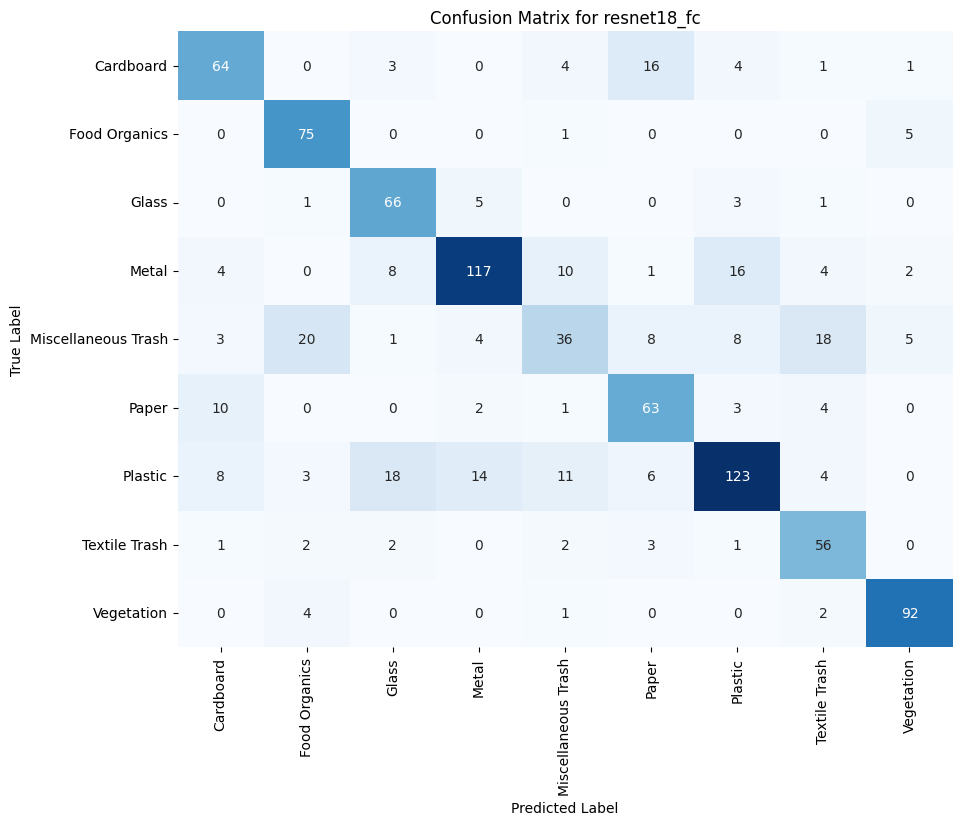

Training resnet18_whole...


  1%|          | 1/100 [00:28<46:14, 28.02s/it]

87.89737176895142 8.86188942193985


  2%|▏         | 2/100 [00:55<45:31, 27.87s/it]

34.59358328580856 6.097505629062653


  3%|▎         | 3/100 [01:23<44:40, 27.64s/it]

21.42500775307417 6.540200173854828


  4%|▍         | 4/100 [01:51<44:48, 28.00s/it]

15.868786126375198 5.280615374445915


  5%|▌         | 5/100 [02:17<43:14, 27.31s/it]

10.720617298036814 4.580739259719849


  6%|▌         | 6/100 [02:45<42:46, 27.30s/it]

8.435788810253143 5.211026638746262


  7%|▋         | 7/100 [03:13<42:54, 27.69s/it]

6.04651743080467 5.109537832438946


  8%|▊         | 8/100 [03:42<43:06, 28.11s/it]

4.8339067795313895 4.911946639418602


  9%|▉         | 9/100 [04:11<43:10, 28.47s/it]

3.8479994111694396 4.599473565816879


 10%|█         | 10/100 [04:38<42:02, 28.02s/it]

3.653634751914069 5.93696066737175


 11%|█         | 11/100 [05:05<41:05, 27.70s/it]

3.986145689850673 4.949528053402901


 11%|█         | 11/100 [05:33<44:57, 30.30s/it]

Early stopping


Accuracy of resnet18_whole: 0.9085


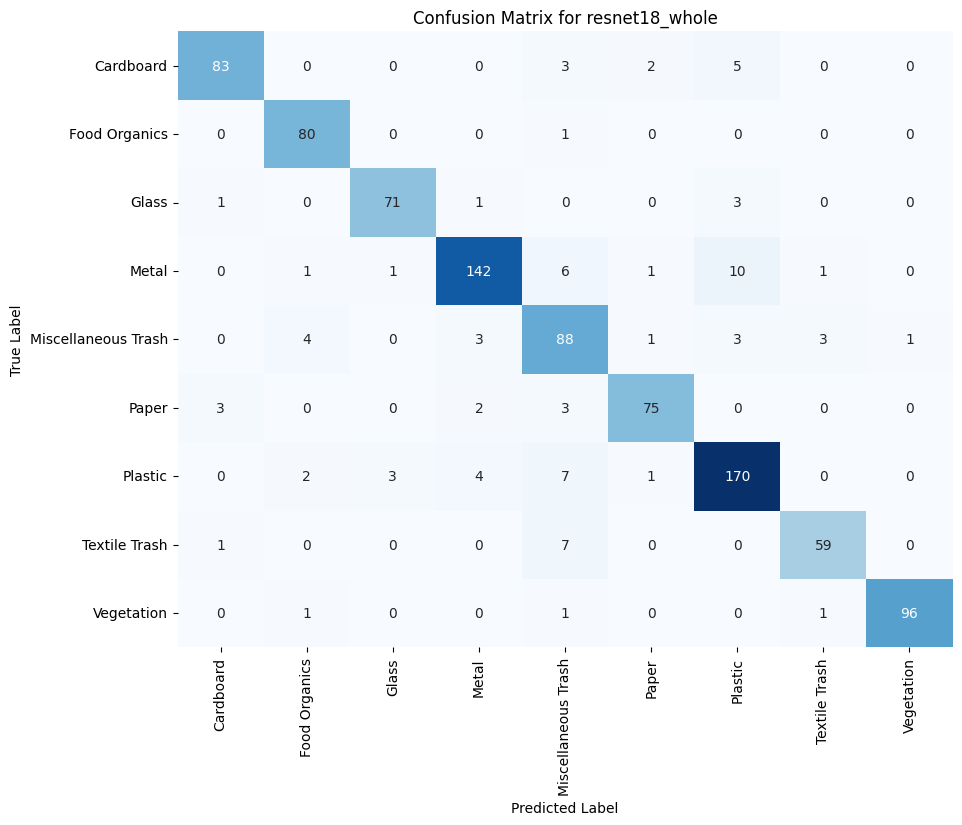

In [11]:
from helper import Trainer
from  helper import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

        
import numpy as np

all_models = {
    # 'alexnet_fc': alexnet_fc,
    # 'alexnet_whole': alexnet_whole,
    'resnet18_fc': resnet18_fc,
    'resnet18_whole': resnet18_whole,
    # 'my_model': my_model
}
plt.figure(figsize=(10, 5))

for model_name, model in all_models.items():
    print(f"Training {model_name}...")
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    model_path = f'models/{model_name}.pth'
    # Early stopping
    early_stopping = EarlyStopping(path=model_path,patience=7, delta=0.01)
    trainer = Trainer(model=model, 
                         criterion=criterion, 
                         optimizer=optimizer, 
                         early_stopping=early_stopping,
                         device=device)
    tr_model = trainer.train(train_loader=train_loader,
                      eval_loader=eval_loader,
                      n_epochs=100)
    
    y_true = []
    y_pred = [] 
    tr_model.eval()    
    with torch.no_grad():
        for input,target in test_loader:
            input = input.to(device)
            target = target.to(device)
            # forward pass
            outputs = tr_model(input)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # calculate accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print(f"Accuracy of {model_name}: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=dataset.classes, columns=dataset.classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)     
    plt.title("Confusion Matrix for " + model_name)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


    

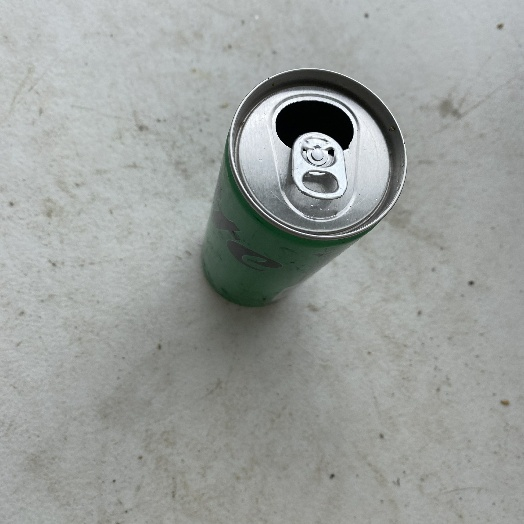

In [ ]:
from PIL import ImasdfasdfccccfffffffffffdfdfasdfasdfdfasdfasdfsadfasdfasdfasdfsadfasdfealWaste/Metal/metal_1.jpg') 
image = image.convert('RGB')